# Knowledge Discovery in Databases I

# Exercise 11: OPTICS with Python, Frequent Pattern Mining (Solution)
## Exercise 11-4: OPTICS (Solution)

## OPTICS

Implement the OPTICS algorithm. After calling the fit method, one should be able to call the `show_reachability_plot()` method, which plots the reach distances in the determined order. Using this information, one can select indices for partitioning the data into clusters. When these indices are given to `show_clustering`, a scatterplot showing the clusters in different colors should be created.

Hints:
* You do not have to care about computational efficiency.
* A dictionary might be a good choice for storing points and their reach distances.
* Representing points as their indices in the original dataset (like in the DBSCAN exercise) might also be helpful.

In [1]:
import numpy as np
import scipy

class OPTICS:
    def __init__(self, eps, min_pts, dist_method='euclidean'):
        self.eps = eps
        self.min_pts = min_pts
        self.dist_method = dist_method
        
        self.cluster_order = {}
        self.seed_list = {}
        
    def fit(self, X):
        # initialize distance matrix
        self.D = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X, self.dist_method))
        
        self.unprocessed = list(range(len(X)))
        while len(self.unprocessed):
        
            if len(self.seed_list) == 0:
                o = self.unprocessed[0]
                self.cluster_order[o] = np.inf
            else:
                o, reach_dist = self._get_min_reach_dist_obj()
                self.cluster_order[o] = reach_dist
                
            self.unprocessed.remove(o)
            neighbors = self._range_query(o)
            for p in neighbors:
                reach_dist = self._reach_dist(p, o)
                self.seed_list[p] = min(reach_dist, self.seed_list.get(p, np.inf))
            
            # seed list is now not sorted, but we always take its minimum so it does not matter
            
    def _get_min_reach_dist_obj(self):
        '''
        Get the obj in seed_list with mininmal reach_dist and remove it from the list. 
        By using this, we do not have to keep the seed_list ordered.
        '''
        keys, values = list(self.seed_list.keys()), list(self.seed_list.values())
        key = keys[np.argmin(values)]
        return key, self.seed_list.pop(key)
            
    def _range_query(self, o):
        '''
        Return the indices of unprocessed points in eps-range of the point at index p (not including the point itself). 
        '''
        mask = np.zeros(self.D.shape[0]).astype(bool)
        mask[self.unprocessed] = True
        eps_mask = np.logical_and(self.D[o,:] <= self.eps,
                                  mask)
        N = np.where(eps_mask)[0] # eps-neighborhood      
        return N
    
    def _reach_dist(self, p, o):
        '''
        smallest dist. s.t. p is directly density-reachable from o
        '''
        dist = self.D[p,o]
        core_dist = self._core_dist(o)
        
        if dist > self.eps:
            assert False
        elif dist >= core_dist:
            return dist
        elif dist < core_dist:
            return core_dist
        
    def _core_dist(self, o):
        '''
        smallest distance such that o is a core object
        '''
        distances = self.D[o,:] # includes d(o,o)
        min_dist = np.sort(distances)[self.min_pts + 1] # +1 to account for d(o,o)
        return min_dist if min_dist < self.eps else np.inf
        
    def show_reachability_plot(self, text=False):
        values = [x if x != np.inf else 2*self.eps for x in self.cluster_order.values()]
        bar_plot = plt.bar(x=range(len(optics.cluster_order)), height=values, )#tick_label=range(len(values)))
        
        if text:
            # a add point indices to the bars
            # taken from https://moonbooks.org/Articles/How-to-add-text-on-a-bar-with-matplotlib-/
            for idx,bar in zip(self.cluster_order.keys(), bar_plot):
                plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                        idx,
                        ha='center', va='bottom', rotation=90)
        plt.show()
        
    def show_clustering(self, X, index_boundaries):
        '''
        Create a scatter plot where cluster labels are encoded in color.
        :param X: The dataset passed to the fit method.
        :param index_boundaries: List of indices separating the clusters in the reachability plot (without 0 and len(X))
        '''
        index_boundaries.insert(0,0)
        index_boundaries.append(len(self.cluster_order))
        labels = []
        for i in range(len(index_boundaries)-1):
            labels += [i] * (index_boundaries[i+1] - index_boundaries[i])
            
        plt.scatter(X[list(self.cluster_order.keys()),0], X[list(self.cluster_order.keys()),1], c=labels)
        plt.show()  



Test your implementation on the following dataset. Play around with different hyperparameters and see if you can get sensible (hierachies of) clusterings.

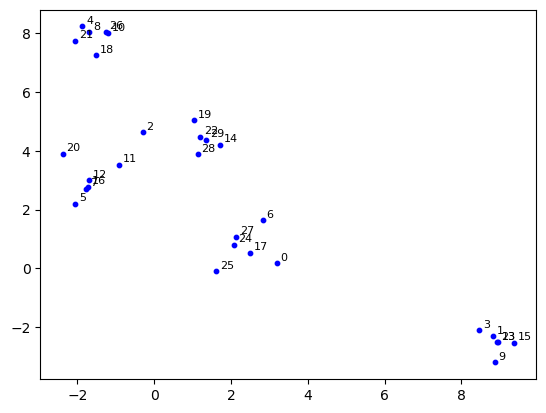

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
X, y_true = make_blobs(n_samples=30, centers=5, cluster_std=0.5, random_state=0)
for i in range(len(X)):
    x,y = X[i]
    plt.scatter(x,y, s=10, c='b')
    plt.text(x+0.1,y+0.1,i, fontsize=8)
plt.show()

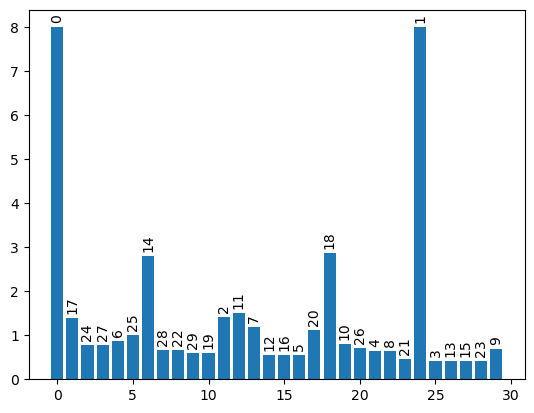

In [3]:
optics = OPTICS(eps=4.0, min_pts=2)
optics.fit(X)
optics.show_reachability_plot(text=True)

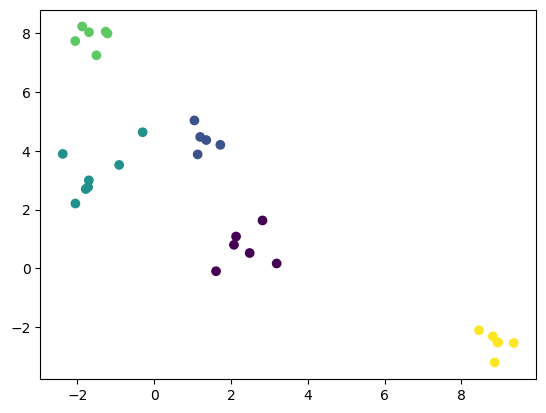

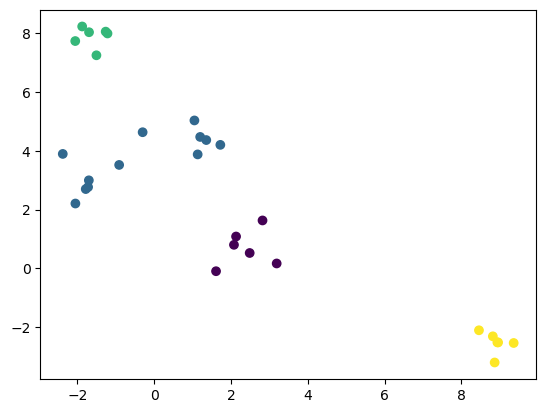

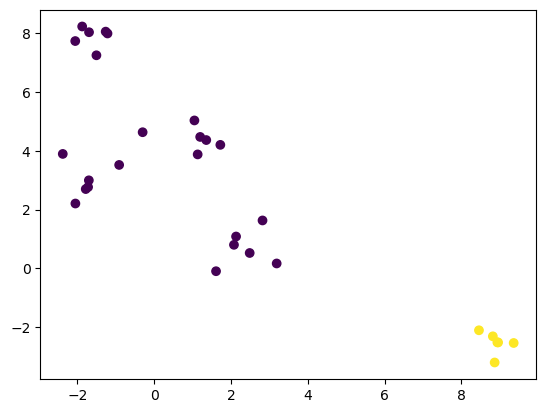

In [4]:
optics.show_clustering(X, [6,11,18,24])
optics.show_clustering(X, [6,18,24])
optics.show_clustering(X, [24])

If we set the hyperparameters suitably, we can extract good cluster partitioning in different granularities.